#### Import library

In [1]:
import shutil
import os
import glob
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import pandas as pd

from pathlib import Path
from collections import OrderedDict


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset,DataLoader

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data.sampler import SubsetRandomSampler

torch.backends.cudnn.enabled = False

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# np.random.seed(1)

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    device = 'cpu'
    print('CUDA is not available.  Training on CPU ...')
else:
    device = 'cuda'
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


#### Dataset 준비

In [3]:
import albumentations as alb
import albumentations.pytorch
train_augmetations = albumentations.Compose([
                              alb.augmentations.geometric.rotate.Rotate(limit=40),
                              alb.augmentations.transforms.Normalize(mean=(0.5), std=(0.5)),
                              alb.pytorch.transforms.ToTensorV2()
                              ],additional_targets={'image2':'image'})

valid_augmetations = albumentations.Compose([
                              alb.augmentations.transforms.Normalize(mean=(0.5), std=(0.5)),
                              alb.pytorch.transforms.ToTensorV2()
                              ],additional_targets={'image2':'image'})

In [4]:
class MyOmniglot_dataset():
    def __init__(self, csv, transform=None):
        self.csv = csv
        self.transforms = transform
        
    def __len__(self):
        return len(self.csv)
        
    def __getitem__(self, index):
        ridx = np.random.choice(len(self.csv))
        
        image1 = self.csv['image_path'][ridx]
        lang1 = self.csv['language'][ridx]
        chr1 = self.csv['character'][ridx]
        
        same_condition = (self.csv.language == lang1) & (self.csv.character == chr1)
        diff_condition = (self.csv.language != lang1) | (self.csv.character != chr1)
        
        self.same = self.csv[same_condition].reset_index()
        self.diff = self.csv[diff_condition].reset_index()
        
        if index % 2 == 0:
            same_idx = np.random.choice(len(self.same))
            image2 = self.same['image_path'][same_idx]
            label = 1
        
        else:
            diff_idx = np.random.choice(len(self.diff))
            image2 = self.diff['image_path'][diff_idx]
            label = 0
        
        image1 = cv2.imread(image1, cv2.COLOR_BGR2GRAY)
        image2 = cv2.imread(image2, cv2.COLOR_BGR2GRAY)
        
        image1 = np.expand_dims(image1, 2)
        image2 = np.expand_dims(image2, 2)
        
        if self.transforms != None:
            augmentation = self.transforms(image=image1, image2=image2)
            img1 = augmentation['image']
            img2 = augmentation['image2']
            
        return img1, img2, label       

In [5]:
train_csv = pd.read_csv('./data/train.csv')
valid_csv = pd.read_csv('./data/validation.csv')

In [6]:
train_data = MyOmniglot_dataset(train_csv, transform = train_augmetations)
valid_data = MyOmniglot_dataset(valid_csv, transform = valid_augmetations)

In [7]:
data = train_data.__getitem__(1)
print(data[0].shape)

torch.Size([1, 105, 105])


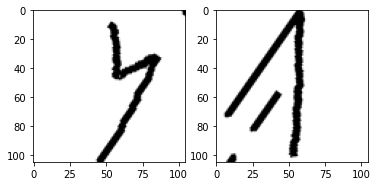

In [8]:
inp = data[0]
lab = data[1]

plt.subplot(121)
plt.imshow(np.transpose(inp, (1, 2, 0)), cmap = 'gray')
plt.subplot(122)
plt.imshow(np.transpose(lab, (1, 2, 0)), cmap = 'gray')
plt.show()

#### Data Loaders 구성

In [9]:
batch_size = 128
num_workers = 0

In [10]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

In [11]:
inp, outp, label = next(iter(train_loader))

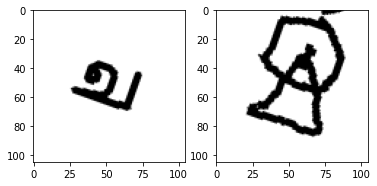

tensor(0)


In [12]:
plt.subplot(121)
# plt.imshow(inp[0], cmap = 'gray')
plt.imshow(np.transpose(inp[1], (1, 2, 0)), cmap = 'gray')
plt.subplot(122)
# plt.imshow(outp[0], cmap = 'gray')
plt.imshow(np.transpose(outp[1], (1, 2, 0)), cmap = 'gray')
plt.show()
print(label[1])

---

#### Neural Network 생성

In [13]:
class Siamese(nn.Module):
    def __init__(self):
        super().__init__()
        
        # input: 1x105x105
        self.conv1 = nn.Conv2d(1, 64, 10)   # 64x96x96  --> 64x48x48
        self.conv2 = nn.Conv2d(64, 128, 7)  # 128x42x42 --> 128x21x21
        self.conv3 = nn.Conv2d(128, 128, 4) # 128x18x18 --> 128x9x9
        self.conv4 = nn.Conv2d(128, 256, 4) # 256x6x6
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256*6*6, 4096)
        self.fc2 = nn.Linear(4096, 1)

        self.relu = nn.ReLU(True)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x1, x2):
         c
        x1 = self.pool(self.relu(self.conv1(x1)))
        x1 = self.pool(self.relu(self.conv2(x1)))
        x1 = self.pool(self.relu(self.conv3(x1)))
        x1 = self.relu(self.conv4(x1))
        
        x2 = self.pool(self.relu(self.conv1(x2)))
        x2 = self.pool(self.relu(self.conv2(x2)))
        x2 = self.pool(self.relu(self.conv3(x2)))
        x2 = self.relu(self.conv4(x2))

        x1 = x1.view(x1.shape[0], -1)
        x2 = x2.view(x2.shape[0], -1)
        
        h1 = self.sigmoid(self.fc1(x1))
        h2 = self.sigmoid(self.fc1(x2))
        
        # L1 distance
        dist = torch.abs(h1-h2)
        
        p = self.sigmoid(self.fc2(dist))

        return p

In [14]:
model = Siamese()
model.to(device)

Siamese(
  (conv1): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1, bias=True)
  (relu): ReLU(inplace=True)
  (sigmoid): Sigmoid()
)

---

#### Loss Function & Optimizer

In [15]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 0.01) # 1e-4
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

---

#### Train and Validate

In [16]:
# # weight initialization
# def weight_init(module):
#     if isinstance(module, torch.nn.Conv2d):
#         module.weight.data.normal_(0.0, 1e-2)
#         module.bias.data.normal_(0.5, 1e-2)
#     elif isinstance(module, torch.nn.Linear):
#         module.weight.data.normal_(0.0, 2e-1)
#         module.bias.data.normal_(0.5, 1e-2)
          

    
epoch = 200
checkpoint = 0
# model.apply(weight_init)

train_loss = torch.zeros(epoch)
valid_loss = torch.zeros(epoch)
train_acc = torch.zeros(epoch)
valid_acc = torch.zeros(epoch)
valid_loss_min = np.Inf

for e in np.arange(epoch): 
    model.train()
    for data1, data2, labels in tqdm(train_loader):
        data1, data2, labels = data1.to(device), data2.to(device), labels.to(device)
        labels = labels.unsqueeze(1).type(torch.float32)

        optimizer.zero_grad()
        logits = model(data1, data2)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss[e] += loss.item()
        equals = (logits > 0.5) == labels
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
        
    train_loss[e] /= len(train_loader)
    train_acc[e] /= len(train_loader)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
    model.eval()
    with torch.no_grad():
        for data1, data2, labels in tqdm(valid_loader):
            data1, data2, labels = data1.to(device), data2.to(device), labels.to(device)
            labels = labels.unsqueeze(1).type(torch.float32)
    
            logits = model(data1, data2)
            loss = criterion(logits, labels)
            
            valid_loss[e] += loss.item()
            equals = (logits > 0.5) == labels
            valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()

    valid_loss[e] /= len(valid_loader)
    valid_acc[e] /= len(valid_loader)

    scheduler.step()

    print('Epoch: {} \tTraining acc: {:.6f} \tTraining Loss: {:.6f} \tValidation acc: {:.6f} \
          \tValidation Loss: {:.6f} \tlr: {:.7f} \tno_update : {}'.format(
          e, train_acc[e], train_loss[e], valid_acc[e], valid_loss[e],
          optimizer.param_groups[0]["lr"], checkpoint))

    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        
        torch.save(model.state_dict(), f'model/model_best_SGD_lr1e-2_scheduler.pt')
        valid_loss_min = valid_loss[e]
        
        checkpoint = 0
    else:
        checkpoint += 1

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 0 	Training acc: 0.521146 	Training Loss: 0.688617 	Validation acc: 0.526928           	Validation Loss: 0.654634 	lr: 0.0099000 	no_update : 0
Validation loss decreased (inf --> 0.654634).  Saving model ...


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 1 	Training acc: 0.716875 	Training Loss: 0.544222 	Validation acc: 0.761137           	Validation Loss: 0.502380 	lr: 0.0098010 	no_update : 0
Validation loss decreased (0.654634 --> 0.502380).  Saving model ...


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 2 	Training acc: 0.804010 	Training Loss: 0.447404 	Validation acc: 0.756483           	Validation Loss: 0.490508 	lr: 0.0097030 	no_update : 0
Validation loss decreased (0.502380 --> 0.490508).  Saving model ...


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 3 	Training acc: 0.831510 	Training Loss: 0.394626 	Validation acc: 0.805020           	Validation Loss: 0.423901 	lr: 0.0096060 	no_update : 0
Validation loss decreased (0.490508 --> 0.423901).  Saving model ...


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 4 	Training acc: 0.856094 	Training Loss: 0.345385 	Validation acc: 0.812500           	Validation Loss: 0.420934 	lr: 0.0095099 	no_update : 0
Validation loss decreased (0.423901 --> 0.420934).  Saving model ...


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 5 	Training acc: 0.871250 	Training Loss: 0.313909 	Validation acc: 0.839927           	Validation Loss: 0.367969 	lr: 0.0094148 	no_update : 0
Validation loss decreased (0.420934 --> 0.367969).  Saving model ...


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 6 	Training acc: 0.885260 	Training Loss: 0.291770 	Validation acc: 0.860206           	Validation Loss: 0.335560 	lr: 0.0093207 	no_update : 0
Validation loss decreased (0.367969 --> 0.335560).  Saving model ...


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 7 	Training acc: 0.889375 	Training Loss: 0.274628 	Validation acc: 0.841922           	Validation Loss: 0.367437 	lr: 0.0092274 	no_update : 0


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 8 	Training acc: 0.892656 	Training Loss: 0.262996 	Validation acc: 0.853890           	Validation Loss: 0.339379 	lr: 0.0091352 	no_update : 1


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 9 	Training acc: 0.903021 	Training Loss: 0.251144 	Validation acc: 0.850898           	Validation Loss: 0.351496 	lr: 0.0090438 	no_update : 2


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 10 	Training acc: 0.909740 	Training Loss: 0.235552 	Validation acc: 0.875665           	Validation Loss: 0.300611 	lr: 0.0089534 	no_update : 3
Validation loss decreased (0.335560 --> 0.300611).  Saving model ...


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 11 	Training acc: 0.913750 	Training Loss: 0.220144 	Validation acc: 0.872008           	Validation Loss: 0.302558 	lr: 0.0088638 	no_update : 0


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 12 	Training acc: 0.925313 	Training Loss: 0.201028 	Validation acc: 0.899435           	Validation Loss: 0.258637 	lr: 0.0087752 	no_update : 1
Validation loss decreased (0.300611 --> 0.258637).  Saving model ...


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 13 	Training acc: 0.929688 	Training Loss: 0.184960 	Validation acc: 0.897274           	Validation Loss: 0.258709 	lr: 0.0086875 	no_update : 0


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 14 	Training acc: 0.936615 	Training Loss: 0.170126 	Validation acc: 0.905253           	Validation Loss: 0.233048 	lr: 0.0086006 	no_update : 1
Validation loss decreased (0.258637 --> 0.233048).  Saving model ...


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 15 	Training acc: 0.941354 	Training Loss: 0.160038 	Validation acc: 0.913065           	Validation Loss: 0.224118 	lr: 0.0085146 	no_update : 0
Validation loss decreased (0.233048 --> 0.224118).  Saving model ...


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 16 	Training acc: 0.943229 	Training Loss: 0.155085 	Validation acc: 0.902427           	Validation Loss: 0.246206 	lr: 0.0084294 	no_update : 0


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 17 	Training acc: 0.943958 	Training Loss: 0.154417 	Validation acc: 0.924867           	Validation Loss: 0.197725 	lr: 0.0083451 	no_update : 1
Validation loss decreased (0.224118 --> 0.197725).  Saving model ...


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 18 	Training acc: 0.947917 	Training Loss: 0.144705 	Validation acc: 0.920545           	Validation Loss: 0.203751 	lr: 0.0082617 	no_update : 0


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 19 	Training acc: 0.950833 	Training Loss: 0.135876 	Validation acc: 0.919714           	Validation Loss: 0.211369 	lr: 0.0081791 	no_update : 1


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 20 	Training acc: 0.952708 	Training Loss: 0.127356 	Validation acc: 0.919714           	Validation Loss: 0.208652 	lr: 0.0080973 	no_update : 2


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 21 	Training acc: 0.955156 	Training Loss: 0.125583 	Validation acc: 0.937500           	Validation Loss: 0.166812 	lr: 0.0080163 	no_update : 3
Validation loss decreased (0.197725 --> 0.166812).  Saving model ...


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 22 	Training acc: 0.959427 	Training Loss: 0.115020 	Validation acc: 0.925033           	Validation Loss: 0.198528 	lr: 0.0079361 	no_update : 0


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 23 	Training acc: 0.959375 	Training Loss: 0.114070 	Validation acc: 0.929023           	Validation Loss: 0.192355 	lr: 0.0078568 	no_update : 1


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 24 	Training acc: 0.963646 	Training Loss: 0.104253 	Validation acc: 0.923703           	Validation Loss: 0.204620 	lr: 0.0077782 	no_update : 2


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 25 	Training acc: 0.962552 	Training Loss: 0.103706 	Validation acc: 0.928856           	Validation Loss: 0.193414 	lr: 0.0077004 	no_update : 3


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 26 	Training acc: 0.963542 	Training Loss: 0.105661 	Validation acc: 0.916722           	Validation Loss: 0.217515 	lr: 0.0076234 	no_update : 4


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 27 	Training acc: 0.962500 	Training Loss: 0.105212 	Validation acc: 0.934840           	Validation Loss: 0.176582 	lr: 0.0075472 	no_update : 5


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 28 	Training acc: 0.966927 	Training Loss: 0.094947 	Validation acc: 0.922207           	Validation Loss: 0.211372 	lr: 0.0074717 	no_update : 6


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 29 	Training acc: 0.967656 	Training Loss: 0.091805 	Validation acc: 0.933511           	Validation Loss: 0.174482 	lr: 0.0073970 	no_update : 7


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 30 	Training acc: 0.968229 	Training Loss: 0.091243 	Validation acc: 0.931516           	Validation Loss: 0.182324 	lr: 0.0073230 	no_update : 8


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 31 	Training acc: 0.969427 	Training Loss: 0.087208 	Validation acc: 0.941489           	Validation Loss: 0.162867 	lr: 0.0072498 	no_update : 9
Validation loss decreased (0.166812 --> 0.162867).  Saving model ...


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 32 	Training acc: 0.969740 	Training Loss: 0.087466 	Validation acc: 0.934508           	Validation Loss: 0.174308 	lr: 0.0071773 	no_update : 0


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 33 	Training acc: 0.973229 	Training Loss: 0.080619 	Validation acc: 0.932513           	Validation Loss: 0.185165 	lr: 0.0071055 	no_update : 1


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 34 	Training acc: 0.973021 	Training Loss: 0.080637 	Validation acc: 0.935007           	Validation Loss: 0.160485 	lr: 0.0070345 	no_update : 2
Validation loss decreased (0.162867 --> 0.160485).  Saving model ...


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 35 	Training acc: 0.972083 	Training Loss: 0.080048 	Validation acc: 0.936669           	Validation Loss: 0.167680 	lr: 0.0069641 	no_update : 0


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 36 	Training acc: 0.975365 	Training Loss: 0.074712 	Validation acc: 0.941323           	Validation Loss: 0.165574 	lr: 0.0068945 	no_update : 1


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 37 	Training acc: 0.974635 	Training Loss: 0.074052 	Validation acc: 0.942154           	Validation Loss: 0.151287 	lr: 0.0068255 	no_update : 2
Validation loss decreased (0.160485 --> 0.151287).  Saving model ...


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 38 	Training acc: 0.976042 	Training Loss: 0.074358 	Validation acc: 0.942653           	Validation Loss: 0.156549 	lr: 0.0067573 	no_update : 0


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 39 	Training acc: 0.977760 	Training Loss: 0.067499 	Validation acc: 0.936503           	Validation Loss: 0.174614 	lr: 0.0066897 	no_update : 1


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 40 	Training acc: 0.976146 	Training Loss: 0.067325 	Validation acc: 0.926862           	Validation Loss: 0.196276 	lr: 0.0066228 	no_update : 2


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 41 	Training acc: 0.975990 	Training Loss: 0.069034 	Validation acc: 0.943816           	Validation Loss: 0.152889 	lr: 0.0065566 	no_update : 3


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 42 	Training acc: 0.976979 	Training Loss: 0.070774 	Validation acc: 0.937999           	Validation Loss: 0.173369 	lr: 0.0064910 	no_update : 4


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 43 	Training acc: 0.976927 	Training Loss: 0.067757 	Validation acc: 0.941988           	Validation Loss: 0.158376 	lr: 0.0064261 	no_update : 5


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 44 	Training acc: 0.976458 	Training Loss: 0.067546 	Validation acc: 0.938165           	Validation Loss: 0.166359 	lr: 0.0063619 	no_update : 6


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 45 	Training acc: 0.977188 	Training Loss: 0.069264 	Validation acc: 0.942487           	Validation Loss: 0.159512 	lr: 0.0062982 	no_update : 7


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 46 	Training acc: 0.978177 	Training Loss: 0.063862 	Validation acc: 0.951130           	Validation Loss: 0.131774 	lr: 0.0062353 	no_update : 8
Validation loss decreased (0.151287 --> 0.131774).  Saving model ...


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 47 	Training acc: 0.980104 	Training Loss: 0.058817 	Validation acc: 0.945977           	Validation Loss: 0.142715 	lr: 0.0061729 	no_update : 0


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 48 	Training acc: 0.980417 	Training Loss: 0.058968 	Validation acc: 0.941656           	Validation Loss: 0.159119 	lr: 0.0061112 	no_update : 1


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 49 	Training acc: 0.981042 	Training Loss: 0.057673 	Validation acc: 0.944481           	Validation Loss: 0.158374 	lr: 0.0060501 	no_update : 2


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 50 	Training acc: 0.978750 	Training Loss: 0.063427 	Validation acc: 0.938830           	Validation Loss: 0.181995 	lr: 0.0059896 	no_update : 3


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 51 	Training acc: 0.980625 	Training Loss: 0.056921 	Validation acc: 0.938996           	Validation Loss: 0.164062 	lr: 0.0059297 	no_update : 4


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 52 	Training acc: 0.980573 	Training Loss: 0.057300 	Validation acc: 0.944980           	Validation Loss: 0.150907 	lr: 0.0058704 	no_update : 5


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 53 	Training acc: 0.980833 	Training Loss: 0.056598 	Validation acc: 0.943650           	Validation Loss: 0.159484 	lr: 0.0058117 	no_update : 6


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 54 	Training acc: 0.981094 	Training Loss: 0.057122 	Validation acc: 0.927028           	Validation Loss: 0.194792 	lr: 0.0057535 	no_update : 7


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 55 	Training acc: 0.982917 	Training Loss: 0.054772 	Validation acc: 0.949801           	Validation Loss: 0.142376 	lr: 0.0056960 	no_update : 8


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 56 	Training acc: 0.982969 	Training Loss: 0.052053 	Validation acc: 0.939993           	Validation Loss: 0.173721 	lr: 0.0056391 	no_update : 9


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 57 	Training acc: 0.981615 	Training Loss: 0.056124 	Validation acc: 0.945811           	Validation Loss: 0.140119 	lr: 0.0055827 	no_update : 10


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 58 	Training acc: 0.984167 	Training Loss: 0.047602 	Validation acc: 0.944315           	Validation Loss: 0.151968 	lr: 0.0055268 	no_update : 11


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 59 	Training acc: 0.978802 	Training Loss: 0.059939 	Validation acc: 0.948305           	Validation Loss: 0.148914 	lr: 0.0054716 	no_update : 12


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 60 	Training acc: 0.982031 	Training Loss: 0.055373 	Validation acc: 0.947307           	Validation Loss: 0.144531 	lr: 0.0054169 	no_update : 13


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 61 	Training acc: 0.982448 	Training Loss: 0.052036 	Validation acc: 0.946310           	Validation Loss: 0.152466 	lr: 0.0053627 	no_update : 14


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 62 	Training acc: 0.983385 	Training Loss: 0.049860 	Validation acc: 0.943816           	Validation Loss: 0.157912 	lr: 0.0053091 	no_update : 15


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 63 	Training acc: 0.984010 	Training Loss: 0.049052 	Validation acc: 0.946975           	Validation Loss: 0.152497 	lr: 0.0052560 	no_update : 16


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 64 	Training acc: 0.986042 	Training Loss: 0.043495 	Validation acc: 0.949468           	Validation Loss: 0.150420 	lr: 0.0052034 	no_update : 17


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 65 	Training acc: 0.985365 	Training Loss: 0.047803 	Validation acc: 0.947473           	Validation Loss: 0.140830 	lr: 0.0051514 	no_update : 18


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 66 	Training acc: 0.984948 	Training Loss: 0.046764 	Validation acc: 0.944315           	Validation Loss: 0.169518 	lr: 0.0050999 	no_update : 19


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 67 	Training acc: 0.984531 	Training Loss: 0.048199 	Validation acc: 0.949136           	Validation Loss: 0.140935 	lr: 0.0050489 	no_update : 20


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 68 	Training acc: 0.985833 	Training Loss: 0.047889 	Validation acc: 0.947473           	Validation Loss: 0.149931 	lr: 0.0049984 	no_update : 21


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 69 	Training acc: 0.986042 	Training Loss: 0.043732 	Validation acc: 0.947806           	Validation Loss: 0.154980 	lr: 0.0049484 	no_update : 22


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 70 	Training acc: 0.986875 	Training Loss: 0.044462 	Validation acc: 0.950632           	Validation Loss: 0.142975 	lr: 0.0048989 	no_update : 23


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 71 	Training acc: 0.987031 	Training Loss: 0.042334 	Validation acc: 0.945479           	Validation Loss: 0.163430 	lr: 0.0048499 	no_update : 24


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 72 	Training acc: 0.986198 	Training Loss: 0.042625 	Validation acc: 0.944315           	Validation Loss: 0.154669 	lr: 0.0048014 	no_update : 25


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 73 	Training acc: 0.987240 	Training Loss: 0.040203 	Validation acc: 0.948969           	Validation Loss: 0.147514 	lr: 0.0047534 	no_update : 26


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 74 	Training acc: 0.986198 	Training Loss: 0.042819 	Validation acc: 0.956782           	Validation Loss: 0.125532 	lr: 0.0047059 	no_update : 27
Validation loss decreased (0.131774 --> 0.125532).  Saving model ...


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 75 	Training acc: 0.987656 	Training Loss: 0.040000 	Validation acc: 0.950798           	Validation Loss: 0.144360 	lr: 0.0046588 	no_update : 0


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 76 	Training acc: 0.987604 	Training Loss: 0.040615 	Validation acc: 0.953790           	Validation Loss: 0.135818 	lr: 0.0046122 	no_update : 1


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 77 	Training acc: 0.987917 	Training Loss: 0.041103 	Validation acc: 0.949302           	Validation Loss: 0.143231 	lr: 0.0045661 	no_update : 2


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 78 	Training acc: 0.988542 	Training Loss: 0.039270 	Validation acc: 0.947806           	Validation Loss: 0.148598 	lr: 0.0045204 	no_update : 3


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 79 	Training acc: 0.988073 	Training Loss: 0.039437 	Validation acc: 0.952128           	Validation Loss: 0.141617 	lr: 0.0044752 	no_update : 4


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 80 	Training acc: 0.988646 	Training Loss: 0.037341 	Validation acc: 0.951629           	Validation Loss: 0.153409 	lr: 0.0044305 	no_update : 5


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 81 	Training acc: 0.988906 	Training Loss: 0.035951 	Validation acc: 0.951961           	Validation Loss: 0.137919 	lr: 0.0043862 	no_update : 6


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 82 	Training acc: 0.988958 	Training Loss: 0.036251 	Validation acc: 0.950465           	Validation Loss: 0.150785 	lr: 0.0043423 	no_update : 7


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 83 	Training acc: 0.987708 	Training Loss: 0.039748 	Validation acc: 0.945479           	Validation Loss: 0.159546 	lr: 0.0042989 	no_update : 8


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 84 	Training acc: 0.989271 	Training Loss: 0.036771 	Validation acc: 0.946809           	Validation Loss: 0.151089 	lr: 0.0042559 	no_update : 9


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 85 	Training acc: 0.988750 	Training Loss: 0.035860 	Validation acc: 0.948637           	Validation Loss: 0.151288 	lr: 0.0042133 	no_update : 10


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 86 	Training acc: 0.988802 	Training Loss: 0.035155 	Validation acc: 0.948305           	Validation Loss: 0.151257 	lr: 0.0041712 	no_update : 11


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 87 	Training acc: 0.987552 	Training Loss: 0.037694 	Validation acc: 0.949634           	Validation Loss: 0.153058 	lr: 0.0041295 	no_update : 12


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 88 	Training acc: 0.989792 	Training Loss: 0.033503 	Validation acc: 0.943816           	Validation Loss: 0.162914 	lr: 0.0040882 	no_update : 13


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 89 	Training acc: 0.989167 	Training Loss: 0.034830 	Validation acc: 0.942819           	Validation Loss: 0.169164 	lr: 0.0040473 	no_update : 14


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 90 	Training acc: 0.988021 	Training Loss: 0.038895 	Validation acc: 0.950798           	Validation Loss: 0.150432 	lr: 0.0040068 	no_update : 15


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 91 	Training acc: 0.989271 	Training Loss: 0.034535 	Validation acc: 0.942487           	Validation Loss: 0.166447 	lr: 0.0039668 	no_update : 16


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 92 	Training acc: 0.989062 	Training Loss: 0.033867 	Validation acc: 0.942653           	Validation Loss: 0.169731 	lr: 0.0039271 	no_update : 17


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch: 93 	Training acc: 0.990573 	Training Loss: 0.033603 	Validation acc: 0.951130           	Validation Loss: 0.147758 	lr: 0.0038878 	no_update : 18


  0%|          | 0/150 [00:00<?, ?it/s]

KeyboardInterrupt: 

---

#### training/validation 분석

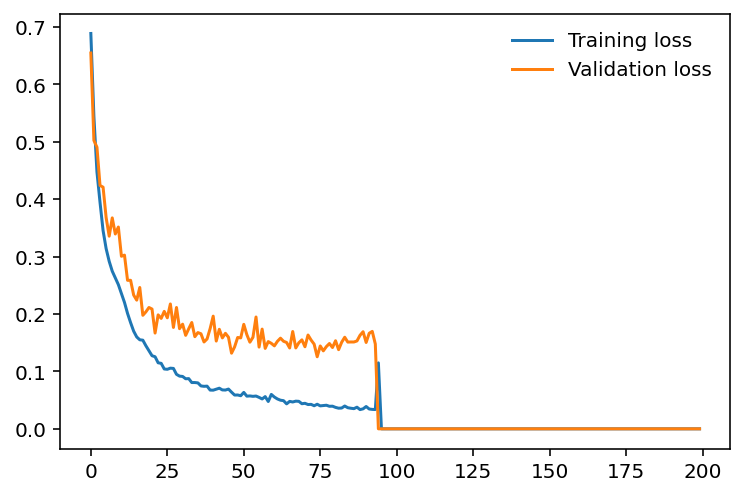

In [17]:
#코드작성
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(frameon=False)

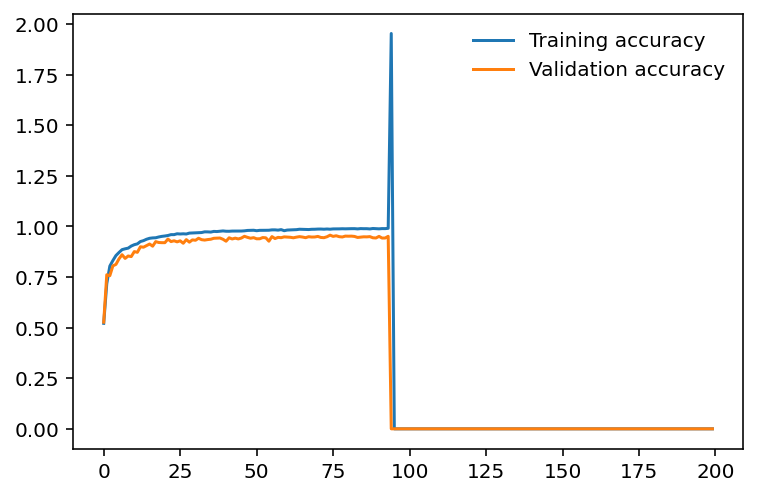

In [18]:
plt.plot(train_acc, label='Training accuracy')
plt.plot(valid_acc, label='Validation accuracy')
plt.legend(frameon=False)

* 최적의 모델 로드

In [33]:
#코드작성
# model.load_state_dict(torch.load('model_best.pt'))
model = Siamese().to(device)
model.load_state_dict(torch.load('model/model_best_SGD_lr1e-3.pt'))

model.eval()

Siamese(
  (conv1): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1, bias=True)
  (relu): ReLU(inplace=True)
  (sigmoid): Sigmoid()
)

---

#### Predict with Test Data 

#### test dataset과 dataloader 생성

In [34]:
class test_dataset():
    def __init__(self, csv, batch_size, transform=None):
        self.csv = csv
        self.batch = batch_size
        self.transforms = transform
        
    def __len__(self):
        return len(self.csv)
        
    def __getitem__(self, index):
        ridx = np.random.choice(len(self.csv))
        image1 = self.csv['image_path'][ridx]
        lang1 = self.csv['language'][ridx]
        chr1 = self.csv['character'][ridx]
        
        same_condition = (self.csv.language == lang1) & (self.csv.character == chr1)
        diff_condition = (self.csv.language != lang1) | (self.csv.character != chr1)
        
        self.same = self.csv[same_condition].reset_index()
        self.diff = self.csv[diff_condition].reset_index()
        
        if index % batch_size == 0:
            same_idx = np.random.choice(len(self.same))
            image2 = self.same['image_path'][same_idx]
            while image1.split('\\')[2] == image2.split('\\')[2]:
                same_i = np.random.choice(len(self.same))
                image2 = self.same['image_path'][same_i]

        else:
            diff_i = np.random.choice(len(self.diff))
            image2 = self.diff['image_path'][diff_i]
            while image1.split('\\')[2] == image2.split('\\')[2]:
                diff_i = np.random.choice(len(self.diff))
                image2 = self.diff['image_path'][diff_i]

        image1 = cv2.imread(image1, cv2.COLOR_BGR2GRAY)
        image2 = cv2.imread(image2, cv2.COLOR_BGR2GRAY)
        
        image1 = np.expand_dims(image1, 2)
        image2 = np.expand_dims(image2, 2)
        
        if self.transforms != None:
            augmentation = self.transforms(image=image1, image2=image2)
            img1 = augmentation['image']
            img2 = augmentation['image2']
            
        return img1, img2

In [35]:
test_augmetations = albumentations.Compose([
                              alb.augmentations.transforms.Normalize(mean=(0.5), std=(0.5)),
                              alb.pytorch.transforms.ToTensorV2()
                              ],additional_targets={'image2':'image'})

In [36]:
test_csv = pd.read_csv('./data/test.csv')

In [37]:
batch_size = 20
test_data = test_dataset(test_csv, batch_size, transform = test_augmetations)

In [38]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

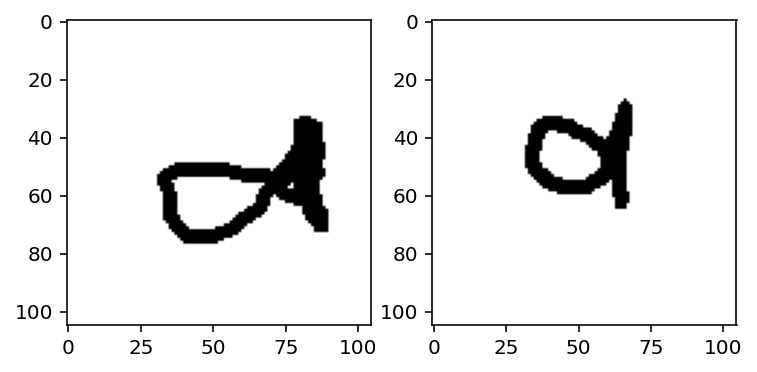

In [39]:
inp, outp = next(iter(test_loader))

plt.subplot(121)
plt.imshow(np.transpose(inp[0], (1, 2, 0)), cmap = 'gray')
plt.subplot(122)
plt.imshow(np.transpose(outp[0], (1, 2, 0)), cmap = 'gray')
plt.show()

In [42]:
correct = 0
model.eval()
with torch.no_grad():
    for data1, data2 in tqdm(test_loader):
        
        data1, data2 = data1.to(device), data2.to(device)
        
        logits = model(data1, data2)
        logits = torch.argmax(logits)

        if logits == 0:
            correct += 1

test_acc = (100*correct)/len(test_loader)
print(f"test accuracy: {correct}/{len(test_loader)} ({test_acc:.2f}%)")

  0%|          | 0/352 [00:00<?, ?it/s]

test accuracy: 321/352 (91.19%)


---